<a href="https://colab.research.google.com/github/FichtnerLukas/retail_demand_analysis/blob/main/data_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis for Guayas Region // Week 1 // Data Preperation

## 1.Import Libraries

In [36]:
import pandas as pd # data manupulation
import numpy as np # numeric operations
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization
from google.colab import drive # Import drive folder to google colab
from pathlib import Path

## 2.Config and Loading DataFrames

### 1.Connect Google Drive

In [41]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2.Set Data Path

In [42]:
DATA_PATH = Path("/content/drive/MyDrive/Time Series Analysis /favorita-grocery-sales-forecasting")

### 3.Data Loading

In [43]:
#Load all supporting CSV files except train.csv.
df_items = pd.read_csv(DATA_PATH / "items.csv")
df_stores = pd.read_csv(DATA_PATH / "stores.csv")
df_oil = pd.read_csv(DATA_PATH / "oil.csv")
df_holidays_events = pd.read_csv(DATA_PATH / "holidays_events.csv")
df_transactions = pd.read_csv(DATA_PATH / "transactions.csv")

In [44]:
 ###Load train.csv in chunks and filter only for given store_ids.
guayas_stores = df_stores.loc[df_stores["state"] == "Guayas", "store_nbr"].unique()
chunks = []
for chunk in pd.read_csv(
    DATA_PATH / "train.csv",
    parse_dates=["date"],
    chunksize=1_000_000,):
    chunks.append(chunk[chunk["store_nbr"].isin(guayas_stores)])
df_train = pd.concat(chunks, ignore_index=True)




/tmp/ipython-input-1507278037.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(


### 4.Reduce Data by Top 3 Product Families

In [45]:
# Compute the number of items per family and select the top 3 families
item_counts = df_items.groupby("family")["item_nbr"].nunique().sort_values(ascending=False)
top_families = item_counts.head(3)


# Get only items that belong to the top families
items_top = df_items[df_items["family"].isin(top_families.index)]  # use .index (family names)

# Keep only training data with those items
df_train = df_train[df_train['item_nbr'].isin(items_top["item_nbr"])]



In [46]:
df_train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
1,18790,2013-01-02,24,105574,12.0,NaN
2,18791,2013-01-02,24,105575,2.0,NaN
3,18792,2013-01-02,24,105577,1.0,NaN
4,18793,2013-01-02,24,105693,7.0,NaN
5,18794,2013-01-02,24,105737,17.0,NaN


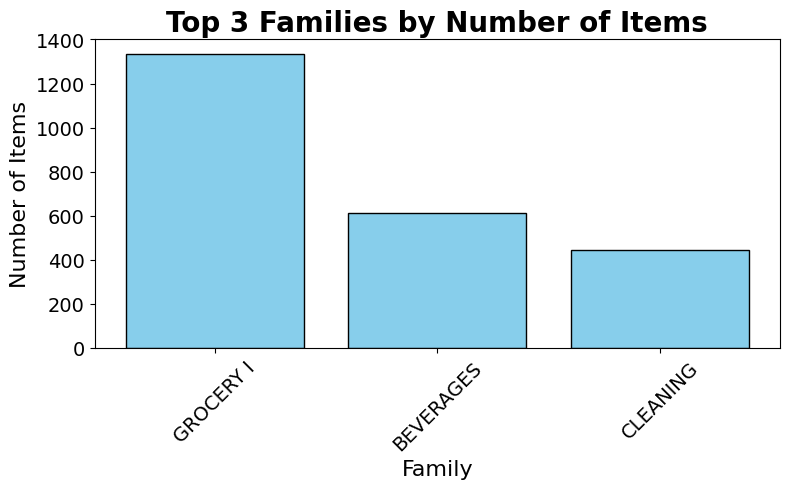

In [47]:
# Plot the top 3 families
plt.figure(figsize=(8, 5))
plt.bar(top_families.index, top_families.values, color='skyblue', edgecolor='black')  # Use .index and .values
plt.title("Top 3 Families by Number of Items", fontsize=20, fontweight='bold')
plt.xlabel("Family", fontsize=16)
plt.ylabel("Number of Items", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

## 3.Missing Value Check

In [48]:
def check_missing(df_dict):
    for name, df in df_dict.items():
        missing = df.isnull().sum()
        print(f"\nMissing values in {name}:")
        print(missing[missing > 0])

dfs = {
    "stores": df_stores,
    "items": df_items,
    "transactions": df_transactions,
    "holidays_events": df_holidays_events,
    "oil": df_oil,
    "train": df_train
}
check_missing(dfs)


Missing values in stores:
Series([], dtype: int64)

Missing values in items:
Series([], dtype: int64)

Missing values in transactions:
Series([], dtype: int64)

Missing values in holidays_events:
Series([], dtype: int64)

Missing values in oil:
dcoilwtico    43
dtype: int64

Missing values in train:
onpromotion    2747275
dtype: int64


## 4.Data Quality Fixes

### 1.Fill onpromotion Nas with False

In [49]:
#Fill onpromotion NAs with False
df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)

/tmp/ipython-input-766353921.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)


### 2.Interpolate Oil Price

In [50]:
 # Interpolate oil price
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].interpolate().fillna(method='bfill')

/tmp/ipython-input-4110722676.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_oil['dcoilwtico'] = df_oil['dcoilwtico'].interpolate().fillna(method='bfill')


### 3.Fill Missing Transactions with 0

In [51]:
# Fill missing transactions with 0
df_transactions["transactions"] = df_transactions["transactions"].fillna(0)

### 4.Adjust negative Sales to 0

In [52]:
# Checking for negative sales (returns)
negative_sales = df_train[df_train['unit_sales'] < 0]

negative_sales.head()  # Viewing negative sales for analysis

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
18589,106658,2013-01-04,34,586824,-2.0,False
54236,309805,2013-01-09,35,1079215,-8.0,False
64452,382905,2013-01-11,27,1097187,-20.0,False
96414,564108,2013-01-15,51,627885,-36.0,False
132903,787522,2013-01-21,24,211205,-5.0,False


In [53]:
# Replacing negative sales with 0 to reflect returns as non-sales
df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: max(x, 0))

### 5.Filling Missing Calender Days

## 5.Outlier Handling

In [55]:
# Fill missing calendar days

full_dates = pd.DataFrame({"date": pd.date_range(df_train["date"].min(), df_train["date"].max())})
store_item_pairs = df_train[["store_nbr", "item_nbr"]].drop_duplicates()
full_index = store_item_pairs.merge(full_dates, how="cross")

df_train = full_index.merge(df_train, on=["store_nbr", "item_nbr", "date"], how="left")
df_train["unit_sales"] = df_train["unit_sales"].fillna(0)
df_train["onpromotion"] = df_train["onpromotion"].fillna(False)

/tmp/ipython-input-2606078039.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train["onpromotion"] = df_train["onpromotion"].fillna(False)


### 1.Z-Score Calculation and Outlier Detection

In [54]:
# Function to calculate Z-score for each group (store-item combination)
def calculate_store_item_zscore(group):
    # Compute mean and standard deviation for each store-item group
    mean_sales = group['unit_sales'].mean()
    std_sales = group['unit_sales'].std()

    # Calculate Z-score for unit_sales (avoiding division by zero for standard deviation), and store it in a new column called z_score
    group['z_score'] = (group['unit_sales'] - mean_sales) / (std_sales if std_sales != 0 else 1)
    return group

# Apply the Z-score calculation to each store-item group, then flatten the index
df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)
df_train_grouped.reset_index(drop=True, inplace=True)

# Define threshold for outliers (e.g., Z-score > 5)
outliers = df_train_grouped[df_train_grouped['z_score'] > 5]

# Print summary
print(f"Number of outliers detected: {len(outliers)}")
outliers.head()

Number of outliers detected: 48485


/tmp/ipython-input-1326790782.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score
188,15666702,2013-12-18,24,96995,14.0,False,7.946399
286,59775862,2015-10-20,24,99197,14.0,False,5.822016
289,60322807,2015-10-26,24,99197,19.0,False,8.276173
721,15717753,2013-12-19,24,103520,27.0,False,6.642670
770,18886543,2014-02-13,24,103520,22.0,False,5.154400


## 5.Feature Engineering

### 1.Date Splitting

In [56]:
#Extrat date by year, month, day and day of the week
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.dayofweek
df_train['is_weekend'] = df_train['day_of_week'].isin([5, 6])

### 2.Rolling Means

In [57]:
# Calculating rolling average of unit_sales
# a 7-day average puts weekday and weekend sales on equal footing
df_train['unit_sales_7d_avg'] = df_train.groupby(['item_nbr', 'store_nbr'])['unit_sales'].transform(lambda x: x.rolling(window=7).mean())

### 3.Lag Features

In [58]:
# Create lag features for sales data:
# lag_1: Sales from the previous day (t-1) for each store-item combination
# lag_7: Sales from one week prior (t-7) for each store-item combination
# for short-term and weekly patterns in sales behavior
df_train['lag_1'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(1)
df_train['lag_7'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(7)

### 4.Merge Holidays

In [59]:
# Convert holiday dates to datetime and merge with training data
df_holidays_events['date'] = pd.to_datetime(df_holidays_events['date']) # Convert holiday dates to datetime and merge with training data
df_train = df_train.merge(df_holidays_events[['date', 'type']], on='date', how='left')
df_train['is_holiday'] = df_train['type'].notna()
df_train = df_train.drop(columns='type')

### 5.Sales Growth & Change Rate

In [60]:
# Measures momentum (for promotions and seasonality)
df_train["sales_change_7d"] = (
    df_train.groupby(["store_nbr", "item_nbr"])["unit_sales"]
    .transform(lambda x: x.pct_change(periods=7))
)

### 6.Economic Influence from Oil Prices

In [61]:
# merge oil to capture marieconomic effects
#rooling oul average to smooth volatility
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_oil["rolling_oil_7d"] = df_oil["dcoilwtico"].rolling(7, min_periods=1).mean()
df_train = df_train.merge(df_oil, on="date", how="left")

In [62]:
df_train.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,is_weekend,unit_sales_7d_avg,lag_1,lag_7,is_holiday,sales_change_7d,dcoilwtico,rolling_oil_7d
0,24,105574,2013-01-02,18790.0,12.0,False,2013,1,2,2,False,NaN,NaN,NaN,False,NaN,93.14,93.140000
1,24,105574,2013-01-03,59692.0,1.0,False,2013,1,3,3,False,NaN,12.0,NaN,False,NaN,92.97,93.083333
2,24,105574,2013-01-04,99664.0,3.0,False,2013,1,4,4,False,NaN,1.0,NaN,False,NaN,93.12,93.092500
3,24,105574,2013-01-05,140805.0,4.0,False,2013,1,5,5,True,NaN,3.0,NaN,True,NaN,NaN,NaN
4,24,105574,2013-01-06,182800.0,7.0,False,2013,1,6,6,True,NaN,4.0,NaN,False,NaN,NaN,NaN


## 6.Exploratory Data Analysis

### 1.Trend Plot

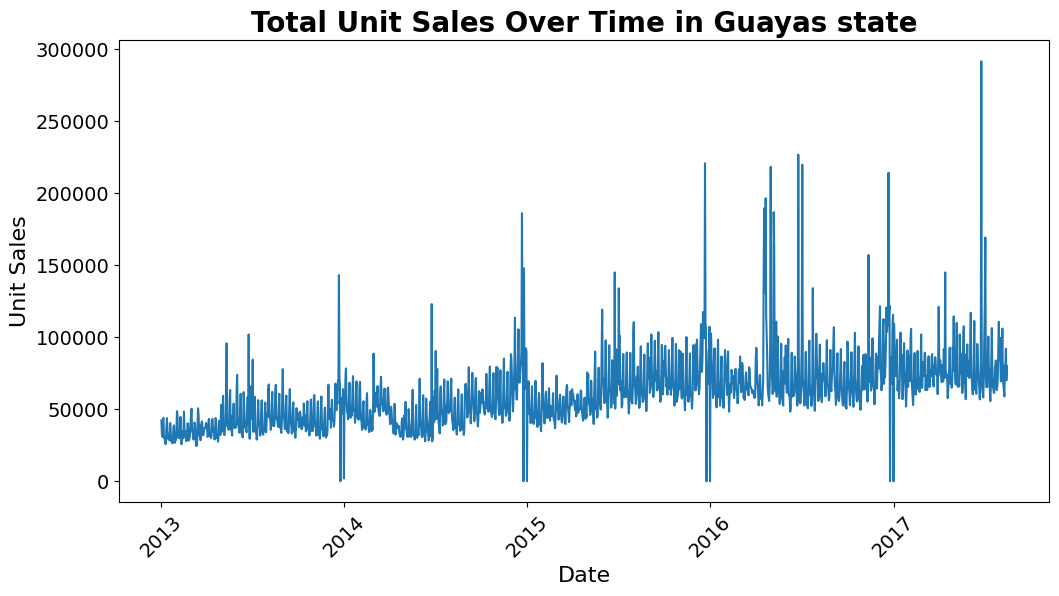

In [63]:
# Aggregating total sales by date
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Plotting the time-series
plt.figure(figsize=(12,6))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Total Unit Sales Over Time in Guayas state', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Unit Sales', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

### 2.Monthly Heatmap

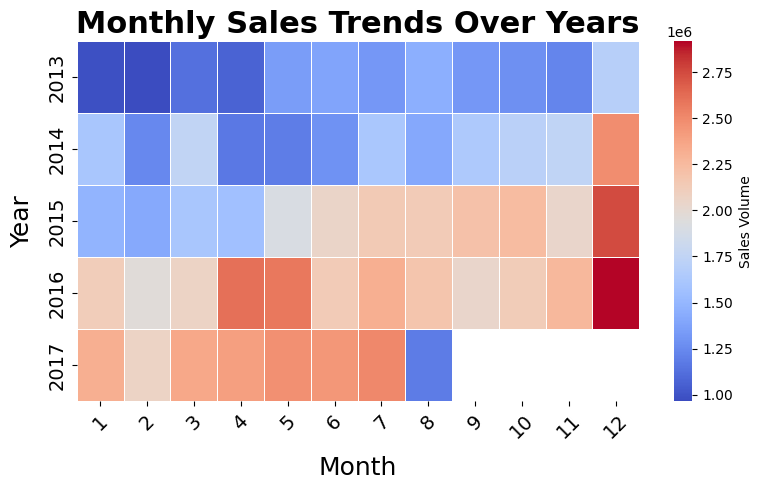

In [64]:
# Aggregating sales by year and month
sales_by_month = df_train.groupby(['year', 'month'])['unit_sales'].sum().unstack()


plt.figure(figsize=(8, 5))  # Increase figure size for better visibility
sns.heatmap(
    sales_by_month,
    cmap='coolwarm',  # Use a diverging colormap for better contrast
    linewidths=0.5,  # Add lines between cells for clarity
    linecolor='white',  # Use white lines for a cleaner look
    cbar_kws={'label': 'Sales Volume'}  # Add a descriptive colorbar label
)

# Customizing title and axes labels
plt.title('Monthly Sales Trends Over Years', fontsize=22, fontweight='bold')
plt.xlabel('Month', fontsize=18, labelpad=10)  # Labelpad adds spacing
plt.ylabel('Year', fontsize=18, labelpad=10)

# Formatting tick labels
plt.xticks(fontsize=14, rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=14)

# Adjust layout for better spacing
plt.tight_layout()

# Display the heatmap
plt.show()

In [65]:
df_train[(df_train['year'] == 2017) & (df_train['month'] == 8) & (df_train['day']>=16)]

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,is_weekend,unit_sales_7d_avg,lag_1,lag_7,is_holiday,sales_change_7d,dcoilwtico,rolling_oil_7d


The Anomalie of low sale trend in the last month (August 2017) occurs  because the sales data ends on 15-08-2017. There are a lack of data for the half month

### 3.Promotion Impact

<Axes: title={'center': 'Promotion vs Non-Promotion Sales'}, xlabel='onpromotion'>

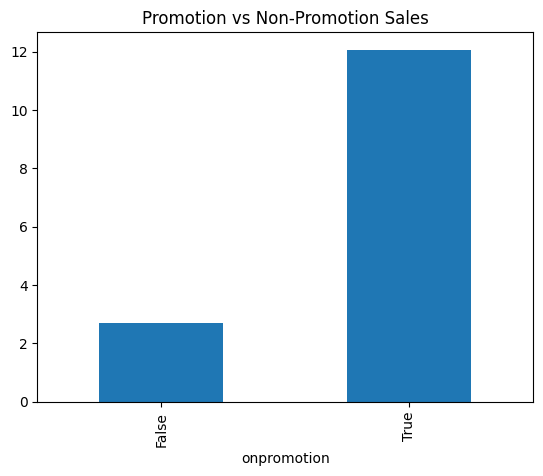

In [67]:
#Promotion Impact - Compare sales during promotion vs. non-promotion periods.
promo_avg = df_train.groupby("onpromotion")["unit_sales"].mean()
promo_avg.plot(kind="bar", title="Promotion vs Non-Promotion Sales")

### 4.Holiday Impact

In [68]:
#the impact of holidays exclude day with zero sales like it was at the very beginning
df_train_no_zero = df_train[df_train.unit_sales > 0]


In [69]:
df_train_no_zero['date'] = pd.to_datetime(df_train_no_zero['date'])
df_holidays_events['date'] = pd.to_datetime(df_holidays_events['date'])

/tmp/ipython-input-88398679.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_no_zero['date'] = pd.to_datetime(df_train_no_zero['date'])


In [70]:
# Merging df_train with zero sales with data with holidays
df_train_holiday = pd.merge(df_train_no_zero, df_holidays_events, on='date', how='left')

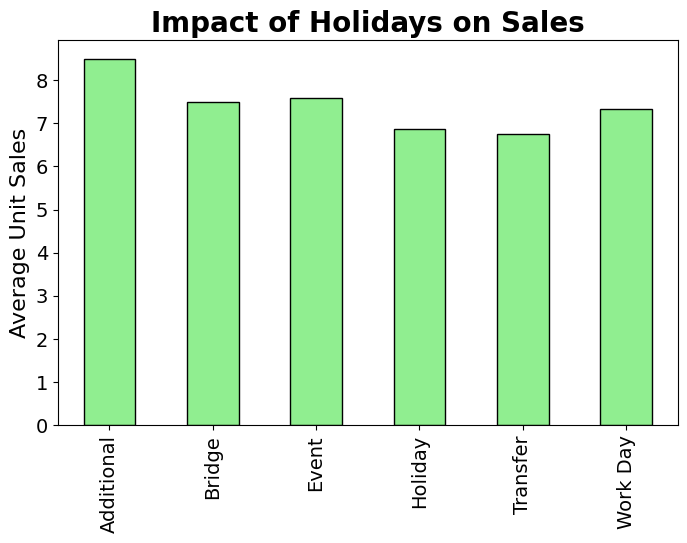

In [71]:
# Aggregating sales by holiday and non-holiday
holiday_sales = df_train_holiday.groupby('type')['unit_sales'].mean()

# Plotting holiday impact
plt.figure(figsize=(8,5))
holiday_sales.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Impact of Holidays on Sales', fontsize=20, fontweight='bold')
plt.ylabel('Average Unit Sales', fontsize=16)
plt.xlabel('')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

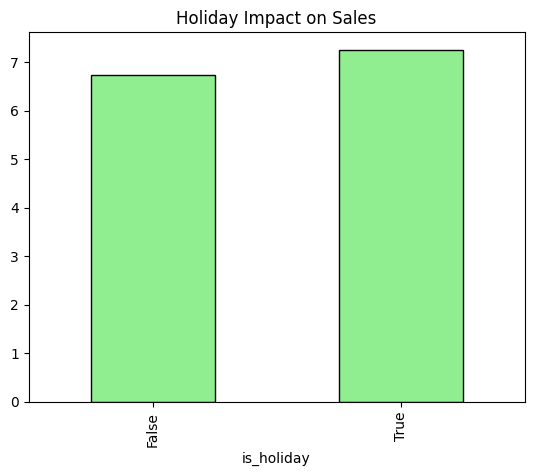

In [72]:
# impact of Holidays
nonzero_sales = df_train[df_train['unit_sales'] > 0]
holiday_avg = nonzero_sales.groupby('is_holiday')['unit_sales'].mean()
holiday_avg.plot(kind='bar', color='lightgreen', edgecolor='black', title="Holiday Impact on Sales")
plt.show()

### 5.Perishable Share

In [66]:
# Measures momentum (for promotions and seasonality)
df_train["sales_change_7d"] = (
    df_train.groupby(["store_nbr", "item_nbr"])["unit_sales"]
    .transform(lambda x: x.pct_change(periods=7)))

### 6.Economic Influence from Oil Prices

In [73]:
# Merging df_train with items to get perishable data
df_items['perishable']= df_items['perishable'].astype(bool)
df_train_items = pd.merge(df_train, df_items, on='item_nbr', how='left')
df_train_items.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,...,unit_sales_7d_avg,lag_1,lag_7,is_holiday,sales_change_7d,dcoilwtico,rolling_oil_7d,family,class,perishable
0,24,105574,2013-01-02,18790.0,12.0,False,2013,1,2,2,...,NaN,NaN,NaN,False,NaN,93.14,93.140000,GROCERY I,1045,False
1,24,105574,2013-01-03,59692.0,1.0,False,2013,1,3,3,...,NaN,12.0,NaN,False,NaN,92.97,93.083333,GROCERY I,1045,False
2,24,105574,2013-01-04,99664.0,3.0,False,2013,1,4,4,...,NaN,1.0,NaN,False,NaN,93.12,93.092500,GROCERY I,1045,False
3,24,105574,2013-01-05,140805.0,4.0,False,2013,1,5,5,...,NaN,3.0,NaN,True,NaN,NaN,NaN,GROCERY I,1045,False
4,24,105574,2013-01-06,182800.0,7.0,False,2013,1,6,6,...,NaN,4.0,NaN,False,NaN,NaN,NaN,GROCERY I,1045,False


In [74]:
df_train_items['perishable'].value_counts()

,count
perishable,
False,35692996


## 7.Save Prepared Dataset

In [75]:
min_date = '2014-01-01'
max_date = '2014-04-01'

df_train_filter = df_train_items[
    (df_train_items['date'] >= min_date) &
    (df_train_items['date'] < max_date)
     ]
#df_train_items.to_csv("guayas_prepared.csv", index=False)
df_train_filter.to_csv('guayas_dataset.csv', index=False)